In [1]:
# Import packages
import pandas as pd
import geopandas as gpd
import numpy as np
import rdrobust as rd
import matplotlib.pyplot as plt

# Load data
sales_df = pd.read_csv("sales_values.csv") # sales values data
oa_gdf = gpd.read_file("London_OA_2016.shp") # opportunity areas shapefile

# Filter data for year 2022 and convert to geodataframe
sales_df = sales_df[sales_df["Year"] == 2022]
sales_gdf = gpd.GeoDataFrame(sales_df, geometry=gpd.points_from_xy(sales_df["Longitude"], sales_df["Latitude"]))

# Spatial join sales data with opportunity areas data
sales_gdf = gpd.sjoin(sales_gdf, oa_gdf, how="left", op="within")

# Define treatment indicator variable
sales_gdf["treatment"] = sales_gdf["index_right"].notnull().astype(int)

# Define running variable as distance to nearest opportunity area boundary
sales_gdf["distance"] = sales_gdf.geometry.apply(lambda x: oa_gdf.boundary.distance(x).min())

# Choose bandwidth using rdrobust.bandwidth
bw_result = rd.rdrobust.bandwidth(sales_gdf["Sales_Value"], sales_gdf["distance"], sales_gdf["treatment"], c=0)
bw = bw_result.bw

# Filter data for observations within bandwidth
sales_gdf = sales_gdf[sales_gdf["distance"].abs() <= bw]

# Estimate effect using rdrobust
rd_result = rd.rdrobust(sales_gdf["Sales_Value"], sales_gdf["distance"], sales_gdf["treatment"], c=0)

# Print results
print(rd_result.summary)

# Plot results
rd.plot(rd_result)
plt.show()

ModuleNotFoundError: No module named 'rdrobust'

In [ ]:
pip install rdrobust

In [1]:
# Import packages
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
openuprncsv = pd.read_csv("data/osopenuprn_202302.csv")
openuprncsv.head()

,UPRN,X_COORDINATE,Y_COORDINATE,LATITUDE,LONGITUDE
0,1,358260.66,172796.5,51.452601,-2.602075
1,26,352967.00,181077.0,51.526633,-2.679361
2,27,352967.00,181077.0,51.526633,-2.679361
3,30,354800.00,180469.0,51.521317,-2.652862
4,31,354796.00,180460.0,51.521236,-2.652918


In [4]:
openuprncsv = openuprncsv[(openuprncsv['X_COORDINATE'] > 490000) & (openuprncsv['X_COORDINATE'] < 570000) & (openuprncsv['Y_COORDINATE'] > 150000) & (openuprncsv['Y_COORDINATE'] < 210000)]
openuprncsv.describe()

,UPRN,X_COORDINATE,Y_COORDINATE,LATITUDE,LONGITUDE
count,6.722480e+06,6.722480e+06,6.722480e+06,6.722480e+06,6.722480e+06
mean,5.268968e+10,5.293313e+05,1.804992e+05,5.150843e+01,-1.377609e-01
std,5.755553e+10,1.513976e+04,1.129795e+04,1.014284e-01,2.182612e-01
min,5.000001e+06,4.900002e+05,1.500002e+05,5.122399e+01,-7.118276e-01
25%,2.071048e+08,5.204650e+05,1.737860e+05,5.144663e+01,-2.656588e-01
50%,1.009169e+10,5.300240e+05,1.808250e+05,5.151192e+01,-1.282248e-01
75%,1.000226e+11,5.377630e+05,1.870530e+05,5.156638e+01,-1.603860e-02
max,2.000047e+11,5.699996e+05,2.100000e+05,5.178083e+01,4.617771e-01


<AxesSubplot:>

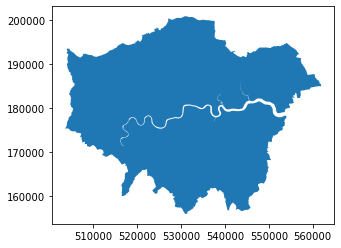

In [5]:
boros = gpd.read_file("data/boros/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp")
ldn = gpd.GeoDataFrame(gpd.GeoSeries(data=boros.unary_union)).rename(columns={0:'geometry'})
ldn = ldn.set_crs(epsg=27700)
ldn.plot()

In [6]:
openuprn2 = gpd.GeoDataFrame(openuprncsv, geometry = gpd.points_from_xy(openuprncsv['X_COORDINATE'], openuprncsv['Y_COORDINATE']), crs = 'EPSG:27700')
openuprn2.head()

,UPRN,X_COORDINATE,Y_COORDINATE,LATITUDE,LONGITUDE,geometry
431563,5000001,528240.0,185465.0,51.553508,-0.151684,POINT (528240.000 185465.000)
431564,5000002,528256.0,186364.0,51.561583,-0.151126,POINT (528256.000 186364.000)
431565,5000003,528256.0,186364.0,51.561583,-0.151126,POINT (528256.000 186364.000)
431566,5000004,528256.0,186364.0,51.561583,-0.151126,POINT (528256.000 186364.000)
431567,5000005,528256.0,186364.0,51.561583,-0.151126,POINT (528256.000 186364.000)


In [7]:
uprn_ldn = gpd.sjoin(openuprn2, ldn, predicate='within', how='inner')
uprn_ldn.head(2)

,UPRN,X_COORDINATE,Y_COORDINATE,LATITUDE,LONGITUDE,geometry,index_right
431563,5000001,528240.0,185465.0,51.553508,-0.151684,POINT (528240.000 185465.000),0
431564,5000002,528256.0,186364.0,51.561583,-0.151126,POINT (528256.000 186364.000),0


In [8]:
uprn_ldn.to_feather("data/uprn_ldn.feather")

In [10]:
uprn_ldn = gpd.read_feather("data/uprn_ldn.feather")
uprn_ldn.head()

,UPRN,X_COORDINATE,Y_COORDINATE,LATITUDE,LONGITUDE,geometry,index_right
431563,5000001,528240.0,185465.0,51.553508,-0.151684,POINT (528240.000 185465.000),0
431564,5000002,528256.0,186364.0,51.561583,-0.151126,POINT (528256.000 186364.000),0
431565,5000003,528256.0,186364.0,51.561583,-0.151126,POINT (528256.000 186364.000),0
431566,5000004,528256.0,186364.0,51.561583,-0.151126,POINT (528256.000 186364.000),0
431567,5000005,528256.0,186364.0,51.561583,-0.151126,POINT (528256.000 186364.000),0


In [14]:
uprnlookup = pd.read_csv("data/ppdiduprnusrnubdc.csv")
uprnlookup.head()

,transactionid,uprn,usrn
0,{DD204FA6-B333-4A06-9E31-7ACABE162EB7},30,4549897
1,{B26F0F8D-4C7A-4DBF-B10A-3336830BF462},31,4549897
2,{241A4A53-DD8C-706B-E050-A8C06205638B},63,4582546
3,{85866A64-627D-143F-E053-6B04A8C06A15},97,4527985
4,{BE61D947-ED06-482E-8274-8B84912C15CB},103,4527985


In [77]:
uprn = pd.merge(uprn_ldn, uprnlookup, how = 'left', left_on = 'UPRN', right_on = 'uprn')
uprn.head()

,UPRN,X_COORDINATE,Y_COORDINATE,LATITUDE,LONGITUDE,geometry,index_right,transactionid,uprn,usrn
0,5000001,528240.0,185465.0,51.553508,-0.151684,POINT (528240.000 185465.000),0,NaN,NaN,NaN
1,5000002,528256.0,186364.0,51.561583,-0.151126,POINT (528256.000 186364.000),0,{1DE03ED3-FFE7-44D8-9F7D-2E1F7AEF2009},5000002.0,20400012.0
2,5000003,528256.0,186364.0,51.561583,-0.151126,POINT (528256.000 186364.000),0,{ACFAC31D-982C-42E5-8B4F-0CFAD8F687FA},5000003.0,20400012.0
3,5000003,528256.0,186364.0,51.561583,-0.151126,POINT (528256.000 186364.000),0,{A2479555-79F5-74C7-E053-6B04A8C0887D},5000003.0,20400012.0
4,5000004,528256.0,186364.0,51.561583,-0.151126,POINT (528256.000 186364.000),0,{E8D3BA46-35F2-49F9-952D-685755233C2E},5000004.0,20400012.0


In [16]:
uprn['uprn'].info()

<class 'pandas.core.series.Series'>
Int64Index: 5274441 entries, 0 to 5274440
Series name: uprn
Non-Null Count   Dtype  
--------------   -----  
288743 non-null  float64
dtypes: float64(1)
memory usage: 80.5 MB


In [78]:
#dropping NAs here to only include properties that we have a transaction id for - this is a big destructive step
uprn = uprn[['UPRN', 'geometry', 'transactionid', 'usrn']]
uprn.head()

,UPRN,geometry,transactionid,usrn
0,5000001,POINT (528240.000 185465.000),NaN,NaN
1,5000002,POINT (528256.000 186364.000),{1DE03ED3-FFE7-44D8-9F7D-2E1F7AEF2009},20400012.0
2,5000003,POINT (528256.000 186364.000),{ACFAC31D-982C-42E5-8B4F-0CFAD8F687FA},20400012.0
3,5000003,POINT (528256.000 186364.000),{A2479555-79F5-74C7-E053-6B04A8C0887D},20400012.0
4,5000004,POINT (528256.000 186364.000),{E8D3BA46-35F2-49F9-952D-685755233C2E},20400012.0


In [2]:
folder_path = 'data/harness/london/'
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

dfs = []
for csv_file in csv_files:
    df = pd.read_csv(os.path.join(folder_path, csv_file))
    dfs.append(df)

price = pd.concat(dfs)

In [3]:
price = gpd.GeoDataFrame(price, geometry = gpd.points_from_xy(price['SignatureHPIDCentroid_x'], price['SignatureHPIDCentroid_y']), crs = 'EPSG:27700')

In [4]:
price.head()

,InternalHPID,SignatureHPID,UPRN,Price,PricePerSquareMetre,LandRegistryTransactionDate,SquareMetreSource,IndexedPrice,IndexedPricePerSquareMetre,LandRegistryPropertyType,SquareMetreSourcePropertyType,NewBuildFlag,Tenure,CouncilTaxBand,LocalAuthorityCode,SignatureHPIDCentroid_x,SignatureHPIDCentroid_y,Unnamed: 17,geometry
0,bc4b4bb1-e0a2-3da3-5354-f61913919a43,e7b433db-a9e5-fdac-39de-ef9ed993a035,9.550586e+07,455000,13382.352941,2014-08-27,Epc Domestic,558755.65,16433.99,F,Flat,N,L,D,E09000001,531736.249,181561.631,NaN,POINT (531736.249 181561.631)
1,8ae40ad0-5929-888f-5e4c-ad116c8d830f,5696338a-e97a-1733-8bc1-5b764862987f,2.000001e+11,59995,1071.339286,1997-09-26,Epc Domestic,486827.36,8693.35,F,Flat,N,L,NaN,E09000001,533546.974,181366.278,NaN,POINT (533546.974 181366.278)
2,4a5bdb17-aa2c-855c-1632-3bee01698bb2,c0d8c729-dc7c-38e1-0a0e-9daaa7349be3,2.000001e+11,345000,4662.162162,2005-05-27,Epc Domestic,1034538.22,13980.25,F,Flat,N,L,E,E09000001,532542.227,181717.327,NaN,POINT (532542.227 181717.327)
3,83d8dd5c-5327-5a48-faf7-32ee1454d0e5,17818366-bb7a-a6ad-38d5-6aa9c164db38,2.000001e+11,540000,9473.684211,2017-01-05,Epc Domestic,615488.72,10798.05,F,Flat,N,L,NaN,E09000001,533546.623,181455.183,NaN,POINT (533546.623 181455.183)
4,c24232c9-d318-59b6-055b-f22231bee64d,562b8c7e-ae42-be07-e288-223eb6c03264,2.000001e+11,362000,4958.904110,2004-08-06,Epc Domestic,1100868.35,15080.39,F,Flat,N,L,F,E09000001,531829.203,181034.448,NaN,POINT (531829.203 181034.448)


In [80]:
price_merge = pd.merge(price, uprn, how = 'left', left_on = "transactionid", right_on = "transactionid")

price_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2530661 entries, 0 to 2530660
Data columns (total 19 columns):
 #   Column                       Dtype   
---  ------                       -----   
 0   priceper                     float64 
 1   year                         int64   
 2   dateoftransfer               object  
 3   propertytype                 object  
 4   duration                     object  
 5   price                        int64   
 6   postcode                     object  
 7   lad21cd                      object  
 8   transactionid                object  
 9   id                           int64   
 10  tfarea                       float64 
 11  numberrooms                  float64 
 12  classt                       int64   
 13  CURRENT_ENERGY_EFFICIENCY    int64   
 14  POTENTIAL_ENERGY_EFFICIENCY  int64   
 15  CONSTRUCTION_AGE_BAND        object  
 16  UPRN                         float64 
 17  geometry                     geometry
 18  usrn                  

In [30]:
#rethink this - just do on cols for priceper and uprn maybe?
#price_merge = price_merge.dropna()
price_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195535 entries, 233484 to 2234302
Data columns (total 19 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   priceper                     195535 non-null  float64 
 1   year                         195535 non-null  int64   
 2   dateoftransfer               195535 non-null  object  
 3   propertytype                 195535 non-null  object  
 4   duration                     195535 non-null  object  
 5   price                        195535 non-null  int64   
 6   postcode                     195535 non-null  object  
 7   lad21cd                      195535 non-null  object  
 8   transactionid                195535 non-null  object  
 9   id                           195535 non-null  int64   
 10  tfarea                       195535 non-null  float64 
 11  numberrooms                  195535 non-null  float64 
 12  classt                       195535 no

In [1]:
price_merge.head()

NameError: name 'price_merge' is not defined

In [83]:
price_merge['UPRN'].info()

<class 'pandas.core.series.Series'>
Int64Index: 2530661 entries, 0 to 2530660
Series name: UPRN
Non-Null Count   Dtype  
--------------   -----  
222104 non-null  float64
dtypes: float64(1)
memory usage: 38.6 MB


In [84]:
price_merge = price_merge.set_geometry('geometry')


In [38]:
sales_gdf = price.copy()
sales_gdf.head()

,InternalHPID,SignatureHPID,UPRN,Price,PricePerSquareMetre,LandRegistryTransactionDate,SquareMetreSource,IndexedPrice,IndexedPricePerSquareMetre,LandRegistryPropertyType,SquareMetreSourcePropertyType,NewBuildFlag,Tenure,CouncilTaxBand,LocalAuthorityCode,SignatureHPIDCentroid_x,SignatureHPIDCentroid_y,Unnamed: 17,geometry
0,bc4b4bb1-e0a2-3da3-5354-f61913919a43,e7b433db-a9e5-fdac-39de-ef9ed993a035,9.550586e+07,455000,13382.352941,2014-08-27,Epc Domestic,558755.65,16433.99,F,Flat,N,L,D,E09000001,531736.249,181561.631,NaN,POINT (531736.249 181561.631)
1,8ae40ad0-5929-888f-5e4c-ad116c8d830f,5696338a-e97a-1733-8bc1-5b764862987f,2.000001e+11,59995,1071.339286,1997-09-26,Epc Domestic,486827.36,8693.35,F,Flat,N,L,NaN,E09000001,533546.974,181366.278,NaN,POINT (533546.974 181366.278)
2,4a5bdb17-aa2c-855c-1632-3bee01698bb2,c0d8c729-dc7c-38e1-0a0e-9daaa7349be3,2.000001e+11,345000,4662.162162,2005-05-27,Epc Domestic,1034538.22,13980.25,F,Flat,N,L,E,E09000001,532542.227,181717.327,NaN,POINT (532542.227 181717.327)
3,83d8dd5c-5327-5a48-faf7-32ee1454d0e5,17818366-bb7a-a6ad-38d5-6aa9c164db38,2.000001e+11,540000,9473.684211,2017-01-05,Epc Domestic,615488.72,10798.05,F,Flat,N,L,NaN,E09000001,533546.623,181455.183,NaN,POINT (533546.623 181455.183)
4,c24232c9-d318-59b6-055b-f22231bee64d,562b8c7e-ae42-be07-e288-223eb6c03264,2.000001e+11,362000,4958.904110,2004-08-06,Epc Domestic,1100868.35,15080.39,F,Flat,N,L,F,E09000001,531829.203,181034.448,NaN,POINT (531829.203 181034.448)


In [6]:
sales_gdf['LocalAuthorityCode'].unique()

array(['E09000001', 'E09000002', 'E09000003', 'E09000004', 'E09000005',
       'E09000006', 'E09000007', 'E09000008', 'E09000009', 'E09000010',
       'E09000011', 'E09000012', 'E09000013', 'E09000014', 'E09000015',
       'E09000016', 'E09000017', 'E09000018', 'E09000019', 'E09000020',
       'E09000021', 'E09000022', 'E09000023', 'E09000024', 'E09000025',
       'E09000026', 'E09000027', 'E09000028', 'E09000029', 'E09000030',
       'E09000031', 'E09000032', 'E09000033'], dtype=object)

In [7]:
oa_gdf = gpd.read_file("data/oa/Opportunity_Areas/Opportunity_Areas.shp")
oa_gdf.head()

,objectid,layerrefer,siterefere,sitename,address,uprn,borough,planning_a,firstadded,lastupdate,...,designatio,boroughdes,classifica,notes,source,extrainfo1,extrainfo2,extrainfo3,missing,geometry
0,1,OPA00000001,21,"Bankside, Borough and London Bridge",None,0,Southwark,None,None,None,...,Opportunity Area,None,None,Please note the GLA does not define boundaries...,https://geo.southwark.gov.uk/connect/analyst/m...,document type: Neighbourhood Plan,https://www.london.gov.uk/what-we-do/planning/...,Adopted date:2015,None,"POLYGON ((531314.000 180683.000, 531361.300 18..."
1,2,OPA00000002,11,Elephant and Castle,None,0,Southwark,None,None,None,...,Opportunity Area,None,None,Please note the GLA does not define boundaries...,https://www.southwark.gov.uk/planning-and-buil...,document type: SPD / OAPF,https://www.london.gov.uk/what-we-do/planning/...,Adopted date:2015,None,"POLYGON ((532338.248 177675.881, 532331.932 17..."
2,3,OPA00000003,8,Croydon,None,0,Croydon,None,None,None,...,Opportunity Area,None,None,Please note the GLA does not define boundaries...,https://www.croydon.gov.uk/sites/default/files...,document type: OAPF,https://www.london.gov.uk/what-we-do/planning/...,Adopted date:20130101,None,"POLYGON ((532022.186 165038.627, 531991.803 16..."
3,4,OPA00000004,12,Euston,None,0,Camden,None,None,None,...,Opportunity Area,None,None,Please note the GLA does not define boundaries...,https://www.eustonareaplan.info/wp-content/upl...,document type: Area Plan,https://www.london.gov.uk/what-we-do/planning/...,Adopted date:20150101,None,"POLYGON ((528631.297 183519.827, 528615.904 18..."
4,5,OPA00000005,37,White City,None,0,Hammersmith and Fulham,None,None,None,...,Opportunity Area,None,None,Please note the GLA does not define boundaries...,https://www.lbhf.gov.uk/planning/regeneration-...,document type: OAPF,https://www.london.gov.uk/what-we-do/planning/...,Adopted date:20180201,None,"POLYGON ((523154.330 180016.258, 523143.370 18..."


In [8]:
oa_gdf['extrainfo3'] = oa_gdf['extrainfo3'].str.replace('Adopted date:', '')

In [9]:
oa_gdf['extrainfo3'] = pd.to_datetime(oa_gdf['extrainfo3'], infer_datetime_format=True)
oa_gdf['extrainfo3']

0    2015-01-01
1    2015-01-01
2    2013-01-01
3    2015-01-01
4    2018-02-01
5    2014-01-01
6    2004-01-01
7    2015-01-01
8    2015-09-01
9    2016-11-01
10   2015-01-01
11   2014-07-01
12   2014-07-01
13   2015-12-01
14   2013-07-01
15   2012-06-01
16   2005-12-01
17   2018-02-01
18   2013-07-01
19   2015-09-01
20   2014-07-01
21   2011-01-01
22   2015-09-01
23   2014-07-01
24   2015-11-01
25   2009-12-01
26   2011-01-01
27   2018-03-01
28   2019-10-14
Name: extrainfo3, dtype: datetime64[ns]

<AxesSubplot:>

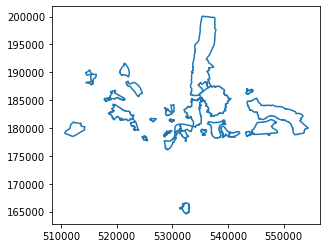

In [38]:
oa_gdf.boundary.plot()

In [29]:
# Spatial join sales_gdf with oa_gdf to find the closest polygon for each point

#oa_gdf['geometry_oa'] = oa_gdf.geometry

# Option 1: Reset the index of oa_gdf before joining
#oa_gdf = oa_gdf.unary_union()

# Spatial join sales_gdf with oa_gdf using geometry as the right geometry column (default)
#sales_gdf = gpd.sjoin(sales_gdf, oa_gdf, how="left", op="intersects", lsuffix="sales", rsuffix="oa")

# Split sales_gdf into two subsets: points inside and outside polygons using geometry_oa
#outside = sales_gdf[~sales_gdf.geometry.within(oa_gdf)]
#inside = sales_gdf[sales_gdf.geometry.within(oa_gdf)]
#inside = sales_gdf[sales_gdf.apply(lambda row: row.geometry_oa.contains(row.geometry) if row.geometry_oa else False, axis=1)].copy()


/opt/conda/lib/python3.10/site-packages/geopandas/base.py:31: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")
/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1428: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/opt/conda/lib/python3.10/site-packages/geopandas/base.py:31: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")
/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1428: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


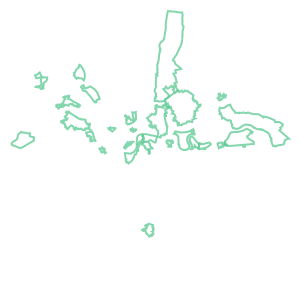

In [36]:
boundary

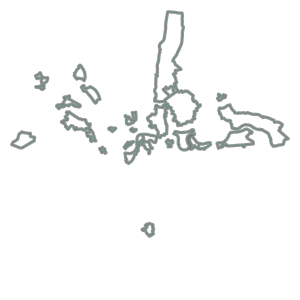

In [37]:
boundary = oa_gdf.boundary.unary_union
buffer = boundary.buffer(100)
buffer

In [11]:
sales_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2761979 entries, 0 to 91522
Data columns (total 19 columns):
 #   Column                         Dtype   
---  ------                         -----   
 0   InternalHPID                   object  
 1   SignatureHPID                  object  
 2   UPRN                           float64 
 3   Price                          int64   
 4   PricePerSquareMetre            float64 
 5   LandRegistryTransactionDate    object  
 6   SquareMetreSource              object  
 7   IndexedPrice                   float64 
 8   IndexedPricePerSquareMetre     float64 
 9   LandRegistryPropertyType       object  
 10  SquareMetreSourcePropertyType  object  
 11  NewBuildFlag                   object  
 12  Tenure                         object  
 13  CouncilTaxBand                 object  
 14  LocalAuthorityCode             object  
 15  SignatureHPIDCentroid_x        float64 
 16  SignatureHPIDCentroid_y        float64 
 17  Unnamed: 17          

In [39]:

# Create a buffer around the boundary of oa_gdf
oa_gdf_buffer = gpd.GeoDataFrame(geometry=oa_gdf.geometry.buffer(100), crs=oa_gdf.crs)
oa_gdf_buffer = oa_gdf_buffer.merge(oa_gdf[['extrainfo3']], left_index=True, right_index=True) 

# Perform a spatial join
sales_gdf = gpd.sjoin(sales_gdf, oa_gdf_buffer, op='intersects')



/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [40]:
sales_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 385792 entries, 1 to 91502
Data columns (total 21 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   InternalHPID                   385792 non-null  object        
 1   SignatureHPID                  385792 non-null  object        
 2   UPRN                           376402 non-null  float64       
 3   Price                          385792 non-null  int64         
 4   PricePerSquareMetre            382210 non-null  float64       
 5   LandRegistryTransactionDate    385792 non-null  object        
 6   SquareMetreSource              385792 non-null  object        
 7   IndexedPrice                   385696 non-null  float64       
 8   IndexedPricePerSquareMetre     382118 non-null  float64       
 9   LandRegistryPropertyType       385792 non-null  object        
 10  SquareMetreSourcePropertyType  382210 non-null  object       

In [165]:
oa_gdf_buffer.head()

,geometry,extrainfo3
0,"POLYGON ((530818.843 180613.577, 530814.460 18...",2015-01-01
1,"POLYGON ((530970.367 179637.630, 530987.023 17...",2015-01-01
2,"POLYGON ((531293.261 166208.364, 531289.914 16...",2013-01-01
3,"POLYGON ((528309.898 183130.913, 528303.890 18...",2015-01-01
4,"POLYGON ((522093.071 180587.236, 522082.172 18...",2018-02-01


In [14]:
sales_gdf['extrainfo3'].describe()

/tmp/ipykernel_14639/2188557390.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  sales_gdf['extrainfo3'].describe()


count                  719214
unique                     17
top       2013-07-01 00:00:00
freq                   118435
first     2004-01-01 00:00:00
last      2019-10-14 00:00:00
Name: extrainfo3, dtype: object

In [41]:
sales_gdf = sales_gdf.drop("index_right", axis = 1)
sales_gdf.head()

,InternalHPID,SignatureHPID,UPRN,Price,PricePerSquareMetre,LandRegistryTransactionDate,SquareMetreSource,IndexedPrice,IndexedPricePerSquareMetre,LandRegistryPropertyType,SquareMetreSourcePropertyType,NewBuildFlag,Tenure,CouncilTaxBand,LocalAuthorityCode,SignatureHPIDCentroid_x,SignatureHPIDCentroid_y,Unnamed: 17,geometry,extrainfo3
1,8ae40ad0-5929-888f-5e4c-ad116c8d830f,5696338a-e97a-1733-8bc1-5b764862987f,2.000001e+11,59995,1071.339286,1997-09-26,Epc Domestic,486827.36,8693.35,F,Flat,N,L,NaN,E09000001,533546.9740,181366.2780,NaN,POINT (533546.974 181366.278),2015-12-01
3,83d8dd5c-5327-5a48-faf7-32ee1454d0e5,17818366-bb7a-a6ad-38d5-6aa9c164db38,2.000001e+11,540000,9473.684211,2017-01-05,Epc Domestic,615488.72,10798.05,F,Flat,N,L,NaN,E09000001,533546.6230,181455.1830,NaN,POINT (533546.623 181455.183),2015-12-01
45,42513910-6f7b-f875-1128-bce84dafe3e7,d57b737b-0539-f274-4fb3-8f999ae6dfcc,2.000001e+11,775000,11742.424242,2016-03-24,Epc Domestic,911982.30,13817.91,F,Flat,N,L,E,E09000001,532358.6555,181951.5060,NaN,POINT (532358.655 181951.506),2015-12-01
48,1d4d4252-6766-db82-f077-b6256ee0d874,05d0e8fe-af68-ed9d-5bd6-63e3d3a86f58,2.000001e+11,70000,1750.000000,1996-12-02,Epc Domestic,614226.68,15355.67,F,Flat,Y,L,D,E09000001,532372.2845,181984.0035,NaN,POINT (532372.285 181984.003),2015-12-01
49,0f757121-e336-46e3-3695-9387b1ed7481,d57b737b-0539-f274-4fb3-8f999ae6dfcc,2.000001e+11,505000,14027.777778,2021-06-25,Epc Domestic,610469.43,16957.48,F,Flat,N,L,D,E09000001,532358.6555,181951.5060,NaN,POINT (532358.655 181951.506),2015-12-01


# NEED TO THINK OF A WAY TO DROP DUPLICATES HERE

In [ ]:
sales_gdf = sales_gdf[sales_gdf.geometry.within(buffer)]
sales_gdf.info()

In [ ]:
oa_gdf.info()

In [19]:
# Use sjoin to get points within polygons
points_within = gpd.sjoin(sales_gdf, oa_gdf.drop("extrainfo3", axis = 1), op="within") #drop extrainfo3 as it is already in sales_gdf
points_within.info()

/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 269762 entries, 421 to 84896
Data columns (total 44 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   InternalHPID                   269762 non-null  object        
 1   SignatureHPID                  269762 non-null  object        
 2   UPRN                           263417 non-null  float64       
 3   Price                          269762 non-null  int64         
 4   PricePerSquareMetre            267337 non-null  float64       
 5   LandRegistryTransactionDate    269762 non-null  object        
 6   SquareMetreSource              269762 non-null  object        
 7   IndexedPrice                   269666 non-null  float64       
 8   IndexedPricePerSquareMetre     267245 non-null  float64       
 9   LandRegistryPropertyType       269762 non-null  object        
 10  SquareMetreSourcePropertyType  267337 non-null  object     

In [20]:

# Use inverse to get points outside polygons
points_outside = sales_gdf[~sales_gdf.index.isin(points_within.index)]

In [21]:
points_outside.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 35385 entries, 35 to 84665
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   InternalHPID                   35385 non-null  object        
 1   SignatureHPID                  35385 non-null  object        
 2   UPRN                           34577 non-null  float64       
 3   Price                          35385 non-null  int64         
 4   PricePerSquareMetre            35173 non-null  float64       
 5   LandRegistryTransactionDate    35385 non-null  object        
 6   SquareMetreSource              35385 non-null  object        
 7   IndexedPrice                   35377 non-null  float64       
 8   IndexedPricePerSquareMetre     35165 non-null  float64       
 9   LandRegistryPropertyType       35385 non-null  object        
 10  SquareMetreSourcePropertyType  35173 non-null  object        
 11  NewBui

In [22]:

# Calculate distance from each point to boundary
points_within["distance"] = points_within.geometry.apply(lambda x: x.distance(boundary))
points_outside["distance"] = -points_outside.geometry.apply(lambda x: x.distance(boundary))

# Concatenate subsets back together
result = gpd.GeoDataFrame(pd.concat([points_within, points_outside], ignore_index=True))

result.head()

/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,InternalHPID,SignatureHPID,UPRN,Price,PricePerSquareMetre,LandRegistryTransactionDate,SquareMetreSource,IndexedPrice,IndexedPricePerSquareMetre,LandRegistryPropertyType,...,northing,designatio,boroughdes,classifica,notes,source,extrainfo1,extrainfo2,missing,distance
0,810f78d6-c0c8-42d9-bd5c-3cb3789cab0c,27252127-e0bb-e003-5116-bb4b1e68013f,6.146424e+06,95000,1266.666667,1997-03-17,Epc Domestic,825535.36,11007.14,F,...,182843.0,Opportunity Area,None,None,Please note the GLA does not define boundaries...,None,document type: OAPF,https://www.london.gov.uk/what-we-do/planning/...,None,6.914593
1,810f78d6-c0c8-42d9-bd5c-3cb3789cab0c,27252127-e0bb-e003-5116-bb4b1e68013f,6.146424e+06,344434,4592.453333,2002-05-31,Epc Domestic,1415265.65,18870.21,F,...,182843.0,Opportunity Area,None,None,Please note the GLA does not define boundaries...,None,document type: OAPF,https://www.london.gov.uk/what-we-do/planning/...,None,6.914593
2,11716160-3707-c4f9-4f84-9765c78018a2,2d74fba1-b181-ee07-f5cf-7a45544d6408,6.196257e+06,445000,10113.636364,2015-05-18,Epc Domestic,545499.69,12397.72,F,...,182843.0,Opportunity Area,None,None,Please note the GLA does not define boundaries...,None,document type: OAPF,https://www.london.gov.uk/what-we-do/planning/...,None,49.452535
3,04394730-c587-e7ba-15fb-697eb2ace5d6,6cb8017c-a5c6-3944-2689-46b38a0bfce6,1.001278e+10,11300000,NaN,2021-05-27,VOA,13984951.54,NaN,O,...,182843.0,Opportunity Area,None,None,Please note the GLA does not define boundaries...,None,document type: OAPF,https://www.london.gov.uk/what-we-do/planning/...,None,17.011714
4,55a4c0d8-bc35-d144-222d-b59166f84f1d,2d74fba1-b181-ee07-f5cf-7a45544d6408,6.196259e+06,445005,10113.750000,2015-05-15,Epc Domestic,545505.82,12397.86,F,...,182843.0,Opportunity Area,None,None,Please note the GLA does not define boundaries...,None,document type: OAPF,https://www.london.gov.uk/what-we-do/planning/...,None,49.452535


In [23]:
result.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 305147 entries, 0 to 305146
Data columns (total 45 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   InternalHPID                   305147 non-null  object        
 1   SignatureHPID                  305147 non-null  object        
 2   UPRN                           297994 non-null  float64       
 3   Price                          305147 non-null  int64         
 4   PricePerSquareMetre            302510 non-null  float64       
 5   LandRegistryTransactionDate    305147 non-null  object        
 6   SquareMetreSource              305147 non-null  object        
 7   IndexedPrice                   305043 non-null  float64       
 8   IndexedPricePerSquareMetre     302410 non-null  float64       
 9   LandRegistryPropertyType       305147 non-null  object        
 10  SquareMetreSourcePropertyType  302510 non-null  object      

In [24]:
#result['dateoftransfer'] = pd.to_datetime(result['dateoftransfer'], infer_datetime_format=True)
result = result[result['LandRegistryTransactionDate'] > result['extrainfo3']]
result

,InternalHPID,SignatureHPID,UPRN,Price,PricePerSquareMetre,LandRegistryTransactionDate,SquareMetreSource,IndexedPrice,IndexedPricePerSquareMetre,LandRegistryPropertyType,...,northing,designatio,boroughdes,classifica,notes,source,extrainfo1,extrainfo2,missing,distance
3,04394730-c587-e7ba-15fb-697eb2ace5d6,6cb8017c-a5c6-3944-2689-46b38a0bfce6,1.001278e+10,11300000,NaN,2021-05-27,VOA,1.398495e+07,NaN,O,...,182843.0,Opportunity Area,None,None,Please note the GLA does not define boundaries...,None,document type: OAPF,https://www.london.gov.uk/what-we-do/planning/...,None,17.011714
7,49affb6d-74e1-a433-b9e3-7b17534a96dd,2d74fba1-b181-ee07-f5cf-7a45544d6408,6.196258e+06,500000,8620.689655,2018-11-16,Epc Domestic,6.116402e+05,10545.52,F,...,182843.0,Opportunity Area,None,None,Please note the GLA does not define boundaries...,None,document type: OAPF,https://www.london.gov.uk/what-we-do/planning/...,None,49.452535
15,8431c7c3-672e-41a0-4c20-2d4867cafe41,62d325ff-5c87-47e4-583d-1e477f9ac0a3,NaN,5166274,6315.738386,2021-09-01,Epc Non Domestic,5.305013e+06,6485.35,O,...,182843.0,Opportunity Area,None,None,Please note the GLA does not define boundaries...,None,document type: OAPF,https://www.london.gov.uk/what-we-do/planning/...,None,35.851160
17,f602b1f7-4e46-0c93-6a76-cec2259c522d,89bccf41-7557-6b6b-d261-bf94f52a80e7,6.650575e+06,97000000,14831.804281,2019-01-18,Epc Non Domestic,1.048547e+08,16032.83,O,...,182843.0,Opportunity Area,None,None,Please note the GLA does not define boundaries...,None,document type: OAPF,https://www.london.gov.uk/what-we-do/planning/...,None,12.495141
21,91b2a201-968a-8669-b937-273db7125403,7e7f4db2-d1c1-0146-512a-f70ea4a334fe,1.000210e+11,790000,5163.398693,2019-02-08,Epc Domestic,9.305550e+05,6082.06,S,...,182843.0,Opportunity Area,None,None,Please note the GLA does not define boundaries...,None,document type: OAPF,https://www.london.gov.uk/what-we-do/planning/...,None,165.823114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305102,8bef2149-106d-3f3f-a95a-7a35b5fd4c2e,971d429e-8cbd-f19b-3f78-d827b4add54b,1.000222e+11,535000,4212.598425,2020-01-09,Epc Domestic,6.475687e+05,5098.97,T,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-189.991888
305122,bc15a489-7d97-5864-e7e2-a10e8e54ac9b,04822822-deea-ddb1-2e82-d462eac3ff3a,1.000222e+11,260000,5200.000000,2022-08-12,Epc Domestic,2.607593e+05,5215.19,F,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-308.172231
305138,bf3ec8bc-d4ce-ddc4-dee5-09b462822f97,25e847fa-dc93-7aa7-3ffc-1417b6bf4125,1.000222e+11,280000,3733.333333,2021-04-23,Epc Domestic,2.934451e+05,3912.60,F,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-69.465911
305139,75dac51f-71dc-7c98-99eb-a29acbe68e8e,3c735434-5723-eef2-c4e1-613d9c3cc255,1.002377e+10,200000,6451.612903,2021-10-22,Epc Domestic,2.051422e+05,6617.49,F,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-191.217086


In [25]:
result.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 109542 entries, 3 to 305144
Data columns (total 45 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   InternalHPID                   109542 non-null  object        
 1   SignatureHPID                  109542 non-null  object        
 2   UPRN                           106672 non-null  float64       
 3   Price                          109542 non-null  int64         
 4   PricePerSquareMetre            108264 non-null  float64       
 5   LandRegistryTransactionDate    109542 non-null  object        
 6   SquareMetreSource              109542 non-null  object        
 7   IndexedPrice                   109536 non-null  float64       
 8   IndexedPricePerSquareMetre     108258 non-null  float64       
 9   LandRegistryPropertyType       109542 non-null  object        
 10  SquareMetreSourcePropertyType  108264 non-null  object      

<AxesSubplot:xlabel='distance', ylabel='Count'>

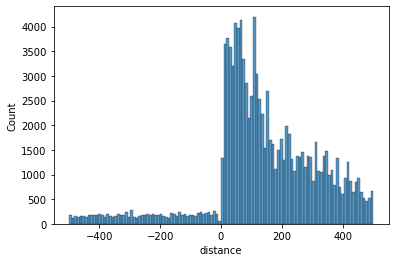

In [26]:
import seaborn as sn
sn.histplot(result, x = 'distance')

<AxesSubplot:xlabel='distance', ylabel='Count'>

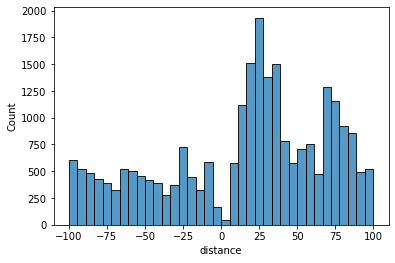

In [51]:
sn.histplot(result2, x = 'distance')

<AxesSubplot:>

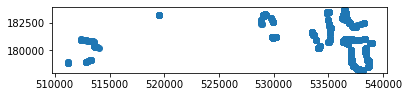

In [53]:
result[(result['distance'] < 30) & (result['distance'] > 0)].plot()

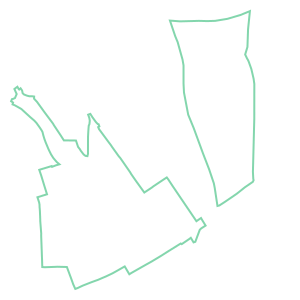

In [64]:
boundary

In [278]:
# # Filter data for year 2022 and convert to geodataframe
#sales_gdf = sales_gdf[sales_gdf["year"] > 2015]

# # Spatial join sales data with opportunity areas data
sales_gdf = gpd.sjoin(sales_gdf, oa_gdf, how="left", op="within", lsuffix="sales", rsuffix="oa")

# # Define treatment indicator variable
sales_gdf["treatment"] = sales_gdf["index_oa"].notnull().astype(int)

#mask = sales_gdf.geometry.intersects(boundary)

#sales_gdf_intersect = sales_gdf[mask]

#sales_gdf_intersect["distance"] = sales_gdf_intersect.geometry.apply(lambda x: np.sign(1 if x.within(boundary) else - 1) * boundary.distance(x))

#boundary = oa_gdf.boundary.unary_union # this returns a shapely geometry

sales_gdf["distance"] = sales_gdf.geometry.apply(lambda x: boundary.distance(x)) # this should work now

# # Define running variable as distance to nearest opportunity area boundary
#sales_gdf["distance"] = sales_gdf.geometry.apply(lambda x: np.sign(1 if x.within(boundary) else - 1) * boundary.distance(x))

#for p in sales_gdf:
#    if p.within(boundary)


/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.


In [280]:
sales_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 15831 entries, 1 to 47671
Data columns (total 50 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   priceper                     15831 non-null  float64 
 1   year                         15831 non-null  int64   
 2   dateoftransfer               15831 non-null  object  
 3   propertytype                 15831 non-null  object  
 4   duration                     15831 non-null  object  
 5   price                        15831 non-null  int64   
 6   postcode                     15831 non-null  object  
 7   lad21cd                      15831 non-null  object  
 8   transactionid                15831 non-null  object  
 9   id                           15831 non-null  int64   
 10  tfarea                       15831 non-null  float64 
 11  numberrooms                  15831 non-null  float64 
 12  classt                       15831 non-null  int64  

In [110]:
index = pd.read_csv("data/Indices-2023-02.csv")
index = index[index['Region_Name'] == "London"]
index.head()

,Date,Region_Name,Area_Code,Index
4,1968-04-01,London,E12000007,1.096815
16,1968-05-01,London,E12000007,1.096815
24,1968-06-01,London,E12000007,1.096815
34,1968-07-01,London,E12000007,1.128152
45,1968-08-01,London,E12000007,1.128152


In [116]:
index['Date'] = pd.to_datetime(index['Date'], infer_datetime_format=True)
index.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 659 entries, 4 to 134942
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         659 non-null    datetime64[ns]
 1   Region_Name  659 non-null    object        
 2   Area_Code    659 non-null    object        
 3   Index        659 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 25.7+ KB


In [118]:
index = index[['Date', 'Index']]

In [188]:
result = pd.merge(result.assign(grouper=result['dateoftransfer'].dt.to_period('M')),
               index.assign(grouper=index['Date'].dt.to_period('M')),
               how='left', on='grouper')
result.head()

,priceper,year,dateoftransfer,propertytype,duration,price,postcode,lad21cd,transactionid,id,...,classifica,notes,source,extrainfo1,extrainfo2,missing,distance,grouper,Date,Index
0,4179.104478,2020,2020-06-03,F,L,280000,N1C 4AE,E09000007,{AC07BBD0-4B22-0445-E053-6C04A8C01E31},18985952,...,None,Please note the GLA does not define boundaries...,https://www.camden.gov.uk/documents/20142/3797...,document type: Planning Framework,https://www.london.gov.uk/what-we-do/planning/...,None,36.65205,2020-06,2020-06-01,119.144165
1,11224.489796,2020,2020-10-23,F,L,550000,N1C 4AF,E09000007,{B82222ED-16CD-6691-E053-6B04A8C02FB2},20305424,...,None,Please note the GLA does not define boundaries...,https://www.camden.gov.uk/documents/20142/3797...,document type: Planning Framework,https://www.london.gov.uk/what-we-do/planning/...,None,36.65205,2020-10,2020-10-01,120.693720
2,3913.043478,2015,2015-11-27,F,L,180000,N1C 4AF,E09000007,{288DCE29-7919-E510-E050-A8C06205480E},19052225,...,None,Please note the GLA does not define boundaries...,https://www.camden.gov.uk/documents/20142/3797...,document type: Planning Framework,https://www.london.gov.uk/what-we-do/planning/...,None,36.65205,2015-11,2015-11-01,110.583992
3,4533.333333,2019,2019-03-01,F,L,204000,N1C 4AF,E09000007,{85866A65-094D-143F-E053-6B04A8C06A15},19015919,...,None,Please note the GLA does not define boundaries...,https://www.camden.gov.uk/documents/20142/3797...,document type: Planning Framework,https://www.london.gov.uk/what-we-do/planning/...,None,36.65205,2019-03,2019-03-01,115.220351
4,11304.347826,2018,2018-10-12,F,L,520000,N1C 4AF,E09000007,{79A74E21-E549-1289-E053-6B04A8C01627},19061011,...,None,Please note the GLA does not define boundaries...,https://www.camden.gov.uk/documents/20142/3797...,document type: Planning Framework,https://www.london.gov.uk/what-we-do/planning/...,None,36.65205,2018-10,2018-10-01,119.166011


In [189]:
result['real_price'] = result['priceper']/result['Index']

In [121]:
result.head()

,priceper,year,dateoftransfer,propertytype,duration,price,postcode,lad21cd,transactionid,id,...,source,extrainfo1,extrainfo2,extrainfo3,missing,distance,grouper,Date,Index,real_price
0,4179.104478,2020,2020-06-03,F,L,280000,N1C 4AE,E09000007,{AC07BBD0-4B22-0445-E053-6C04A8C01E31},18985952,...,https://www.camden.gov.uk/documents/20142/3797...,document type: Planning Framework,https://www.london.gov.uk/what-we-do/planning/...,2004-01-01,None,36.65205,2020-06,2020-06-01,119.144165,35.076031
1,11224.489796,2020,2020-10-23,F,L,550000,N1C 4AF,E09000007,{B82222ED-16CD-6691-E053-6B04A8C02FB2},20305424,...,https://www.camden.gov.uk/documents/20142/3797...,document type: Planning Framework,https://www.london.gov.uk/what-we-do/planning/...,2004-01-01,None,36.65205,2020-10,2020-10-01,120.693720,92.999783
2,3913.043478,2015,2015-11-27,F,L,180000,N1C 4AF,E09000007,{288DCE29-7919-E510-E050-A8C06205480E},19052225,...,https://www.camden.gov.uk/documents/20142/3797...,document type: Planning Framework,https://www.london.gov.uk/what-we-do/planning/...,2004-01-01,None,36.65205,2015-11,2015-11-01,110.583992,35.385261
3,4533.333333,2019,2019-03-01,F,L,204000,N1C 4AF,E09000007,{85866A65-094D-143F-E053-6B04A8C06A15},19015919,...,https://www.camden.gov.uk/documents/20142/3797...,document type: Planning Framework,https://www.london.gov.uk/what-we-do/planning/...,2004-01-01,None,36.65205,2019-03,2019-03-01,115.220351,39.344901
4,11304.347826,2018,2018-10-12,F,L,520000,N1C 4AF,E09000007,{79A74E21-E549-1289-E053-6B04A8C01627},19061011,...,https://www.camden.gov.uk/documents/20142/3797...,document type: Planning Framework,https://www.london.gov.uk/what-we-do/planning/...,2004-01-01,None,36.65205,2018-10,2018-10-01,119.166011,94.862182


Text(0.5, 1.0, 'Price per square metre by distance from OA boundary')

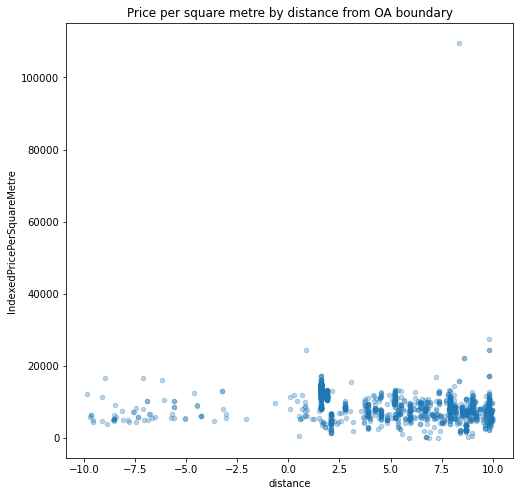

In [33]:
plt.figure(figsize=(8,8))
ax = plt.subplot(1,1,1)
result[(result['distance'] < 10) & (result['distance'] > -10)].plot.scatter(x="distance", y="IndexedPricePerSquareMetre", ax=ax, alpha = 0.3)
plt.title("Price per square metre by distance from OA boundary")


<AxesSubplot:xlabel='distance', ylabel='Count'>

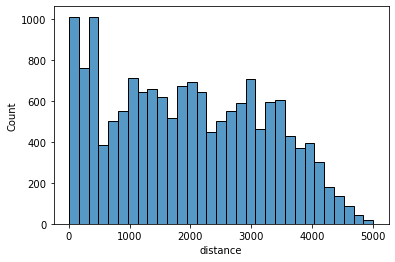

In [201]:
import seaborn as sn
sn.histplot(sales_gdf, x = 'distance')

In [153]:
# Spatial join sales data with opportunity areas data
sales_gdf = gpd.sjoin(sales_gdf, oa_gdf, how="left", op="within", lsuffix="sales", rsuffix="oa")
sales_gdf.info()

/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
/tmp/ipykernel_1515/1977583316.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:27700
Right CRS: PROJCS["unnamed",GEOGCS["Airy 1830",DATUM["unknown ...



<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 15831 entries, 1 to 47671
Data columns (total 49 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   priceper                     15831 non-null  float64 
 1   year                         15831 non-null  int64   
 2   dateoftransfer               15831 non-null  object  
 3   propertytype                 15831 non-null  object  
 4   duration                     15831 non-null  object  
 5   price                        15831 non-null  int64   
 6   postcode                     15831 non-null  object  
 7   lad21cd                      15831 non-null  object  
 8   transactionid                15831 non-null  object  
 9   id                           15831 non-null  int64   
 10  tfarea                       15831 non-null  float64 
 11  numberrooms                  15831 non-null  float64 
 12  classt                       15831 non-null  int64  

In [154]:
import spreg as sp

# Load data

# # Filter data for year 2022 and convert to geodataframe
# sales_gdf = sales_gdf[sales_gdf["year"] > 2010]

# # Spatial join sales data with opportunity areas data
# sales_gdf = gpd.sjoin(sales_gdf, oa_gdf, how="left", op="within", lsuffix="sales", rsuffix="oa")

# Define treatment indicator variable
sales_gdf["treatment"] = sales_gdf["index_oa"].notnull().astype(int)

# Define running variable as distance to nearest opportunity area boundary
sales_gdf["distance"] = sales_gdf.geometry.apply(lambda x: oa_gdf.boundary.distance(x).min())

# Choose bandwidth using np.percentile
bw = np.percentile(sales_gdf["distance"], 10) # 10th percentile of distance as bandwidth

# Filter data for observations within bandwidth
sales_gdf = sales_gdf[sales_gdf["distance"].abs() <= bw]

# Define outcome variable as log of sales value
#sales_gdf["log_sales_value"] = np.log(sales_gdf["priceper"])

# Define explanatory variables as treatment indicator and distance
X = sales_gdf[["treatment", "distance"]].values


# Estimate spatial lag model using spreg.ML_Lag
model = sp.OLS(y=sales_gdf["priceper"].to_numpy()[:, None], x = sales_gdf["numberrooms"].to_numpy()[:, None])

# Print results
print(model.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :     dep_var                Number of Observations:        1593
Mean dependent var  :   9824.6134                Number of Variables   :           2
S.D. dependent var  :   4610.3526                Degrees of Freedom    :        1591
R-squared           :      0.0410
Adjusted R-squared  :      0.0404
Sum squared residual:32451324933.368                F-statistic           :     68.0103
Sigma-square        :20396810.140                Prob(F-statistic)     :   3.367e-16
S.E. of regression  :    4516.283                Log likelihood        :  -15665.172
Sigma-square ML     :20371202.093                Akaike info criterion :   31334.343
S.E of regression ML:   4513.4468                Schwarz criterion     :   31345.090

--------------------------------------------------------------------------

In [155]:
sales_gdf

,priceper,year,dateoftransfer,propertytype,duration,price,postcode,lad21cd,transactionid,id,...,planning_authority,removeddate,sitename,sitereference,source,status,uprn_oa,runtime,treatment,distance
1047,10408.163265,2018,2018-11-16,F,L,510000,N1C 4AF,E09000007,{7E86B6FB-1CE7-458C-E053-6B04A8C0C84C},19083867,...,,None,King's Cross - St Pancras,19,Planning Framework,Adopted,None,09/18/2019,1,36.586836
2209,6219.765031,2013,2013-11-21,F,L,360000,NW1 0AA,E09000007,{9F60927C-8EC5-4E5F-B531-DB174E15E246},19012301,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,130.497234
2224,12151.162791,2016,2016-03-31,T,F,1045000,NW1 0AB,E09000007,{34428D7E-503F-B86C-E050-A8C06205059C},19002722,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,245.971769
2294,12500.000000,2021,2021-12-17,T,L,675000,NW1 0BH,E09000007,{D707E535-A903-0AD9-E053-6B04A8C067CC},19028874,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,266.710141
2296,11620.370370,2016,2016-01-15,T,L,627500,NW1 0BH,E09000007,{2D1E4B26-9535-FCD1-E050-A8C0630544EC},19028874,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,266.710141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45571,10396.975425,2012,2012-03-16,F,L,550000,WC1N 1JP,E09000007,{642D9101-E908-4C14-96A8-A908A29E03F1},19049567,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,278.229190
46833,9547.169811,2015,2015-08-28,F,L,506000,WC1X 8QP,E09000007,{25EA59F9-FE9D-4D50-E050-A8C0630562D0},19048996,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,162.102690
46925,6353.135314,2011,2011-04-19,F,L,385000,WC1X 9DB,E09000007,{A6999999-76AC-4A35-AAF7-6A4FB7C00E7A},19024202,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,276.189832
46932,9007.244958,2011,2011-05-19,F,L,460000,WC1X 9DB,E09000007,{962AD011-A95D-4D4C-B299-AC71969F2ABC},19040636,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,234.819186


In [ ]:
# # Filter data for year 2022 and convert to geodataframe
sales_gdf = sales_gdf[sales_gdf["year"] > 2015]

# # Spatial join sales data with opportunity areas data
sales_gdf = gpd.sjoin(sales_gdf, oa_gdf, how="left", op="within", lsuffix="sales", rsuffix="oa")

# # Define treatment indicator variable
sales_gdf["treatment"] = sales_gdf["index_oa"].notnull().astype(int)

# # Define running variable as distance to nearest opportunity area boundary
sales_gdf["distance"] = sales_gdf.geometry.apply(lambda x: oa_gdf.boundary.distance(x).min())

# # Choose bandwidth using rdrobust.bandwidth
bw = rd.rdrobust(sales_gdf["priceper"], sales_gdf["distance"], sales_gdf["treatment"]).bandwidth

# # Filter data for observations within bandwidth
sales_gdf = sales_gdf[sales_gdf["distance"].abs() <= bw]

# # Estimate effect using rdrobust
rd_result = rd.rdrobust(sales_gdf["priceper"], sales_gdf["distance"], sales_gdf["treatment"])
# # Print results
print(rd_result.summary)

# # Plot results
rd.plot(rd_result)
plt.show()


In [ ]:
sales_gdf